# Extracting an Order Parameter

In [63]:
import os
import re

from nexusformat.nexus import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from nxs_analysis_tools import load_data, Scissors
from nxs_analysis_tools.fitting import LinecutModel
from nxs_analysis_tools.datareduction import load_transform, reciprocal_lattice_params

def load_transform(path, print_tree=True):
    """
    Load data obtained from nxrefine output from a specified path.

    Parameters
    ----------
    path : str
        The path to the transform data file.

    print_tree : bool, optional
        Whether to print the data tree upon loading. Default True.

    Returns
    -------
    data : nxdata object
        The loaded data stored in a nxdata object.
    """

    g = nxload(path)

    data = NXdata(NXfield(g.entry.transform.data.nxdata.transpose(2, 1, 0), name='counts'),
                  (g.entry.transform.Qh, g.entry.transform.Qk, g.entry.transform.Ql))

    print(data.tree) if print_tree else None

    return data

class TempDependence:
    """
    A class for analyzing temperature-dependent scattering datasets collected at CHESS (ID4B).

    The `TempDependence` class facilitates the loading, processing, and analysis of scattering
    data across different temperatures. It includes methods for handling datasets, setting
    lattice parameters, performing linecuts, modeling the data, and visualizing the results.

    Attributes
    ----------
    sample_directory : str
        Path to the directory containing the datasets.
    xlabel : str
        Label for the x-axis of plots, determined by the axis of the linecuts.
    datasets : dict
        Dictionary storing datasets keyed by temperature.
    temperatures : list of str
        List of temperatures for which data is available.
    scissors : dict
        Dictionary of Scissors objects, one for each temperature, used for data manipulation and
        linecut operations.
    linecuts : dict
        Dictionary storing the linecut data for each temperature.
    linecutmodels : dict
        Dictionary of LinecutModel objects, one for each temperature, used for fitting the linecuts.
    a, b, c, al, be, ga : float or None
        Lattice parameters (a, b, c, alpha, beta, gamma) of the crystal.
    a_star, b_star, c_star, al_star, be_star, ga_star : float or None
        Reciprocal lattice parameters (a*, b*, c*, alpha*, beta*, gamma*).

    Methods
    -------
    set_temperatures(temperatures):
        Set the list of temperatures for the datasets.
    find_temperatures():
        Set the list of temperatures by automatically scanning the sample directory.
    set_sample_directory(path):
        Set the directory path where the datasets are located.
    initialize():
        Initialize Scissors and LinecutModel objects for each temperature.
    set_data(temperature, data):
        Set the dataset for a specific temperature.
    load_transforms(temperatures_list=None, print_tree=True):
        Load transform datasets (from nxrefine) based on temperature.
    load_datasets(file_ending='hkli.nxs', temperatures_list=None, print_tree=True):
        Load datasets (CHESS format) from the specified folder.
    get_sample_directory():
        Get the folder path where the datasets are located.
    clear_datasets():
        Clear the datasets stored in the TempDependence instance.
    set_Lattice_params(lattice_params):
        Set lattice parameters and calculate reciprocal lattice parameters.
    set_window(window, verbose=False):
        Set the extents of the integration window for each temperature.
    set_center(center):
        Set the central coordinate for the linecut for each temperature.
    cut_data(center=None, window=None, axis=None, verbose=False):
        Perform data cutting for each temperature dataset.
    plot_linecuts(vertical_offset=0, **kwargs):
        Plot the linecuts obtained from data cutting.
    plot_linecuts_heatmap(ax=None, **kwargs):
        Plot a heatmap of the linecuts obtained from data cutting.
    highlight_integration_window(temperature=None, **kwargs):
        Display the integration window plot for a specific temperature.
    plot_integration_window(temperature=None, **kwargs):
        Plot the integration window cross-sections for a specific temperature.
    set_model_components(model_components):
        Set the model components for all line cut models.
    set_param_hint(*args, **kwargs):
        Set parameter hints for all line cut models.
    make_params():
        Create parameters for all line cut models.
    guess():
        Make initial parameter guesses for all line cut models.
    print_initial_params():
        Print the initial parameter values for all line cut models.
    plot_initial_guess():
        Plot the initial guess for all line cut models.
    fit(verbose=False):
        Fit the line cut models for each temperature.
    plot_fit(mdheadings=False, **kwargs):
        Plot the fit results for each temperature.
    print_fit_report():
        Print the fit report for each temperature.
    """

    def __init__(self):
        """
        Initialize the TempDependence class with default values.
        """

        self.sample_directory = None
        self.xlabel = ''
        self.datasets = {}
        self.temperatures = []
        self.scissors = {}
        self.linecuts = {}
        self.linecutmodels = {}
        self.a, self.b, self.c, self.al, self.be, self.ga, \
            self.a_star, self.b_star, self.c_star, self.al_star, self.be_star, self.ga_star \
            = [None] * 12

    def set_temperatures(self, temperatures):
        """
        Set the list of temperatures for the datasets.

        Parameters
        ----------
        temperatures : list
            List of temperatures to set.
        """
        self.temperatures = temperatures

    def find_temperatures(self):
        """
        Set the list of temperatures by automatically scanning the sample directory.
        """

        # Assert that self.sample_directory must exist
        if self.sample_directory is None:
            raise ValueError("Sample directory is not set. Use set_sample_directory(path) first.")

        # Clear existing temperatures
        self.temperatures = []

        # Search for nxrefine .nxs files
        for item in os.listdir(self.sample_directory):
            pattern = r'_(\d+)\.nxs'
            match = re.search(pattern, item)
            if match:
                # Identify temperature
                temperature = match.group(1)
                self.temperatures.append(temperature)
        # Convert all temperatures to int temporarily to sort temperatures list
        self.temperatures = [int(t) for t in self.temperatures]
        self.temperatures.sort()
        self.temperatures = [str(t) for t in self.temperatures]

    def set_sample_directory(self, path):
        """
        Set the directory path where the datasets are located.

        Parameters
        ----------
        path : str
            Path to the sample directory.
        """
        self.sample_directory = os.path.normpath(path)

    def initialize(self):
        """
        Initialize Scissors and LinecutModel objects for each temperature.
        """
        for temperature in self.temperatures:
            self.scissors[temperature] = Scissors()
            self.scissors[temperature] = LinecutModel()

    def set_data(self, temperature, data):
        """
        Set the dataset for a specific temperature.

        Parameters
        ----------
        temperature : str
            Temperature for which to set the data.
        data : object
            The dataset to be set.
        """
        self.datasets[temperature] = data

    def load_transforms(self, temperatures_list=None, print_tree=True):
        """
        Load transform datasets (from nxrefine) based on temperature.

        Parameters
        ----------
        temperatures_list : list of int or None, optional
            List of temperatures to load. If None, all available temperatures are loaded.
        print_tree : bool, optional
            Whether to print the data tree upon loading. Default True.
        """
        # Convert all temperatures to strings
        if temperatures_list:
            temperatures_list = [str(t) for t in temperatures_list]

        # Clear existing temperatures before loading files
        self.temperatures = []

        # Identify files to load
        items_to_load = []
        # Search for nxrefine .nxs files
        for item in os.listdir(self.sample_directory):
            pattern = r'_(\d+)\.nxs'
            match = re.search(pattern, item)
            if match:
                # Identify temperature
                temperature = match.group(1)
                # print(f'Temperature = {temperature}')
                if (temperatures_list is None) or (temperature in temperatures_list):
                    # Prepare file to be loaded
                    self.temperatures.append(temperature)
                    items_to_load.append(item)
                    # print(f'Preparing to load {temperature} K data: {item}')
        # Convert all temperatures to int temporarily to sort temperatures list before loading
        self.temperatures = [int(t) for t in self.temperatures]

        loading_template = pd.DataFrame({'temperature': self.temperatures, 'filename': items_to_load})
        loading_template = loading_template.sort_values(by='temperature')
        self.temperatures = loading_template['temperature']
        self.temperatures = [str(t) for t in self.temperatures]
        items_to_load = loading_template['filename'].to_list()

        for i, item in enumerate(items_to_load):
            path = os.path.join(self.sample_directory, item)

            # Save dataset
            try:
                self.datasets[self.temperatures[i]] = load_transform(path, print_tree)
            except Exception as e:
                # Report temperature that was unable to load, then raise exception.
                temp_failed = self.temperatures[i]
                print(f"Failed to load data for temperature {temp_failed} K from file {item}. Error: {e}")
                raise  # Re-raise the exception

            # Initialize scissors object
            self.scissors[self.temperatures[i]] = Scissors()
            self.scissors[self.temperatures[i]].set_data(self.datasets[self.temperatures[i]])

            # Initialize linecutmodel object
            self.linecutmodels[self.temperatures[i]] = LinecutModel()

    def load_datasets(self, file_ending='hkli.nxs', temperatures_list=None, print_tree=True):
        """
        Load datasets (CHESS format) from the specified folder.

        Parameters
        ----------
        file_ending : str, optional
            The file extension of the datasets to be loaded. The default is 'hkli.nxs'.
        temperatures_list : list of int or None, optional
            The list of specific temperatures to load. If None, all available temperatures are
            loaded. The default is None.
        print_tree : bool, optional
            Whether to print the data tree upon loading. Default True.
        """
        temperature_folders = []  # Empty list to store temperature folder names
        for item in os.listdir(self.sample_directory):
            try:
                temperature_folders.append(int(item))  # If folder name can be int, add it
            except ValueError:
                pass  # Otherwise don't add it
        temperature_folders.sort()  # Sort from low to high T
        temperature_folders = [str(i) for i in temperature_folders]  # Convert to strings

        self.temperatures = temperature_folders

        if temperatures_list is not None:
            self.temperatures = [str(t) for t in temperatures_list]

        # Load .nxs files
        for T in self.temperatures:
            for file in os.listdir(os.path.join(self.sample_directory, T)):
                if file.endswith(file_ending):
                    filepath = os.path.join(self.sample_directory, T, file)

                    # Load dataset at each temperature
                    self.datasets[T] = load_data(filepath, print_tree)

                    # Initialize scissors object at each temperature
                    self.scissors[T] = Scissors()
                    self.scissors[T].set_data(self.datasets[T])

                    # Initialize linecutmodel object at each temperature
                    self.linecutmodels[T] = LinecutModel()

    def get_sample_directory(self):
        """
        Get the folder path where the datasets are located.

        Returns
        -------
        str
            The folder path.
        """
        return self.sample_directory

    def clear_datasets(self):
        """
        Clear the datasets stored in the TempDependence instance.
        """
        self.datasets = {}

    def set_lattice_params(self, lattice_params):
        """
        Set lattice parameters and calculate reciprocal lattice parameters.

        Parameters
        ----------
        lattice_params : tuple
            Tuple containing lattice parameters (a, b, c, al, be, ga).
        """
        self.a, self.b, self.c, self.al, self.be, self.ga = lattice_params
        self.a_star, self.b_star, self.c_star, \
            self.al_star, self.be_star, self.ga_star = reciprocal_lattice_params(lattice_params)

    def set_window(self, window, verbose=False):
        """
        Set the extents of the integration window for each temperature.

        Parameters
        ----------
        window : tuple
            Extents of the window for integration along each axis.
        verbose : bool, optional
            Enables printout of linecut axis and integrated axes. Default is False.
        """
        for T in self.temperatures:
            if verbose:
                print("----------------------------------")
                print("T = " + T + " K")
            self.scissors[T].set_window(window, verbose)

    def set_center(self, center):
        """
        Set the central coordinate for the linecut for each temperature.

        Parameters
        ----------
        center : tuple
            Central coordinate around which to perform the linecut.
        """
        for T in self.temperatures:
            self.scissors[T].set_center(center)

    def cut_data(self, center=None, window=None, axis=None, verbose=False):
        """
        Perform data cutting for each temperature dataset.

        Parameters
        ----------
        center : tuple, optional
            The center point for cutting the data.
            Defaults to the first temperature's center if None.
        window : tuple, optional
            The window size for cutting the data.
            Defaults to the first temperature's window if None.
        axis : int or None, optional
            The axis along which to perform the cutting.
            Defaults to the longest axis in `window` if None.
        verbose : bool, optional
            Enables printout of linecut progress. Default is False.

        Returns
        -------
        dict
            A dictionary of linecuts obtained from the cutting operation.
        """

        for T in self.temperatures:
            if verbose:
                print("-------------------------------")
                print("Cutting T = " + T + " K data...")
            self.scissors[T].set_center(center)
            self.scissors[T].set_window(window)
            self.scissors[T].cut_data(axis=axis, verbose=verbose)
            self.linecuts[T] = self.scissors[T].linecut
            self.linecutmodels[T].set_data(self.linecuts[T])

        xlabel_components = [self.linecuts[self.temperatures[0]].axes
                             if i == self.scissors[self.temperatures[0]].axis
                             else str(c) for i, c in
                             enumerate(self.scissors[self.temperatures[0]].center)]
        self.xlabel = ' '.join(xlabel_components)

        return self.linecuts

    def plot_linecuts(self, vertical_offset=0, **kwargs):
        """
        Plot the linecuts obtained from data cutting.

        Parameters
        ----------
        vertical_offset : float, optional
            The vertical offset between linecuts on the plot. The default is 0.
        **kwargs
            Additional keyword arguments to be passed to the plot function.
        """
        fig, ax = plt.subplots()

        # Get the Viridis colormap
        cmap = mpl.colormaps.get_cmap('viridis')

        for i, linecut in enumerate(self.linecuts.values()):
            x_data = linecut[linecut.axes].nxdata
            y_data = linecut[linecut.signal].nxdata + i * vertical_offset
            ax.plot(x_data, y_data, color=cmap(i / len(self.linecuts)), label=self.temperatures[i],
                    **kwargs)

        ax.set(xlabel=self.xlabel,
               ylabel=self.linecuts[self.temperatures[0]].signal)

        # Get the current legend handles and labels
        handles, labels = plt.gca().get_legend_handles_labels()

        # Reverse the order of handles and labels
        handles = handles[::-1]
        labels = labels[::-1]

        # Create a new legend with reversed order
        plt.legend(handles, labels)

        return fig, ax

    def plot_linecuts_heatmap(self, ax=None, **kwargs):
        """
        Plot the linecuts obtained from data cutting.

        Parameters
        ----------
        ax : matplotlib.axes.Axes, optional
            The axes on which to plot the heatmap. If None, a new figure and axes
            are created. The default is None.
        **kwargs
            Additional keyword arguments to be passed to the `pcolormesh` function.

        Returns
        -------
        QuadMesh
            The plotted heatmap object.
        """

        # Retrieve linecut data for the first temperature and extract x-axis data
        cut = self.linecuts[self.temperatures[0]]
        x = cut[cut.axes].nxdata

        # Convert the list of temperatures to a NumPy array for the y-axis
        y = np.array([int(t) for t in self.temperatures])

        # Collect counts from each temperature and ensure they are numpy arrays
        v = [self.linecuts[T].counts.nxdata for T in self.temperatures]

        # Convert list of arrays to a 2D array for the heatmap
        v_2d = np.array(v)

        # Create the grid for the heatmap
        X, Y = np.meshgrid(x, y)

        # Plot using pcolormesh
        if ax is None:
            _, ax = plt.subplots()
        p = ax.pcolormesh(X, Y, v_2d, **kwargs)
        plt.colorbar(p, label='counts')
        ax.set(xlabel=cut.axes, ylabel=r'$T$ (K)')

        return p

    def highlight_integration_window(self, temperature=None, **kwargs):
        """
        Displays the integration window plot for a specific temperature,
        or for the first temperature if none is provided.

        Parameters
        ----------
        temperature : str, optional
            The temperature at which to display the integration window plot. If provided, the plot
            will be generated using the dataset corresponding to the specified temperature. If not
            provided, the integration window plots will be generated for the first temperature.
        **kwargs : keyword arguments, optional
            Additional keyword arguments to customize the plot.
        """

        if temperature is not None:
            p = self.scissors[
                self.temperatures[0]].highlight_integration_window(
                data=self.datasets[temperature], **kwargs
            )
        else:
            p = self.scissors[self.temperatures[0]].highlight_integration_window(
                data=self.datasets[self.temperatures[0]], **kwargs
            )

        return p

    def plot_integration_window(self, temperature=None, **kwargs):
        """
        Plots the three principal cross-sections of the integration volume on
        a single figure for a specific temperature, or for the first temperature
        if none is provided.

        Parameters
        ----------
        temperature : str, optional
            The temperature at which to plot the integration volume. If provided,
            the plot will be generated using the dataset corresponding to the
            specified temperature. If not provided, the integration window plots
            will be generated for the first temperature.

        **kwargs : keyword arguments, optional
            Additional keyword arguments to customize the plot.
        """

        if temperature is not None:
            p = self.scissors[self.temperatures[0]].plot_integration_window(**kwargs)
        else:
            p = self.scissors[self.temperatures[0]].plot_integration_window(**kwargs)

        return p

    def set_model_components(self, model_components):
        """
        Set the model components for all line cut models.

        This method sets the same model components for all line cut models in the
        analysis. It iterates over each line cut model and calls their respective
        `set_model_components` method with the provided `model_components`.

        Parameters
        ----------
        model_components : Model or iterable of Model
            The model components to set for all line cut models.

        """
        [linecutmodel.set_model_components(model_components) for
         linecutmodel in self.linecutmodels.values()]

    def set_param_hint(self, *args, **kwargs):
        """
        Set parameter hints for all line cut models.

        This method sets the parameter hints for all line cut models in the analysis.
        It iterates over each line cut model and calls their respective `set_param_hint` method
        with the provided arguments and keyword arguments.

        Parameters
        ----------
        *args
            Variable length argument list.
        **kwargs
            Arbitrary keyword arguments.

        """
        [linecutmodel.set_param_hint(*args, **kwargs)
         for linecutmodel in self.linecutmodels.values()]

    def make_params(self):
        """
        Make parameters for all line cut models.

        This method creates the parameters for all line cut models in the analysis.
        It iterates over each line cut model and calls their respective `make_params` method.
        """
        [linecutmodel.make_params() for linecutmodel in self.linecutmodels.values()]

    def guess(self):
        """
        Make initial parameter guesses for all line cut models.

        This method generates initial parameter guesses for all line cut models in the analysis.
        It iterates over each line cut model and calls their respective `guess` method.

        """
        [linecutmodel.guess() for linecutmodel in self.linecutmodels.values()]

    def print_initial_params(self):
        """
        Print the initial parameter values for all line cut models.

        This method prints the initial parameter values for all line cut models
        in the analysis. It iterates over each line cut model and calls their
        respective `print_initial_params` method.

        """
        [linecutmodel.print_initial_params() for linecutmodel in self.linecutmodels.values()]

    def plot_initial_guess(self):
        """
        Plot the initial guess for all line cut models.

        This method plots the initial guess for all line cut models in the analysis.
        It iterates over each line cut model and calls their respective `plot_initial_guess` method.

        """
        for T, linecutmodel in self.linecutmodels.items():
            _, ax = plt.subplots()
            ax.set(title=T + ' K')
            linecutmodel.plot_initial_guess()

    def fit(self, verbose=False):
        """
        Fit the line cut models.

        This method fits the line cut models for each temperature in the analysis.
        It iterates over each line cut model, performs the fit, and prints the fitting progress.

        Parameters
        ----------
       verbose : bool, optional
            Enables printout of fitting progress. Default False.

        """
        for T, linecutmodel in self.linecutmodels.items():
            if verbose:
                print(f"Fitting {T} K  data...")
            linecutmodel.fit()
            if verbose:
                print("Done.")
        print("Fits completed.")

    def plot_fit(self, mdheadings=False, **kwargs):
        """
        Plot the fit results.

        This method plots the fit results for each temperature in the analysis.
        It iterates over each line cut model, calls their respective `plot_fit` method,
        and sets the xlabel, ylabel, and title for the plot.

        """
        for T, linecutmodel in self.linecutmodels.items():
            # Create a markdown heading for the plot
            if mdheadings:
                display(Markdown(f"### {T} K Fit Results"))
            # Plot fit
            linecutmodel.plot_fit(xlabel=self.xlabel,
                                  ylabel=self.datasets[self.temperatures[0]].signal,
                                  title=f"{T} K",
                                  **kwargs)

    def print_fit_report(self):
        """
        Plot the fit results.

        This method plots the fit results for each temperature in the analysis.
        It iterates over each line cut model, calls their respective `plot_fit` method,
        and sets the xlabel, ylabel, and title for the plot.

        """
        for T, linecutmodel in self.linecutmodels.items():
            print(f"[[[{T} K Fit Report]]]")
            linecutmodel.print_fit_report()


In [67]:
# from nxs_analysis_tools.chess import TempDependence

xtl = TempDependence()
xtl.set_sample_directory('example_data/order_parameter/nxrefine/CsV3Sb5/sample_1b/')
xtl.load_transforms(print_tree=False)

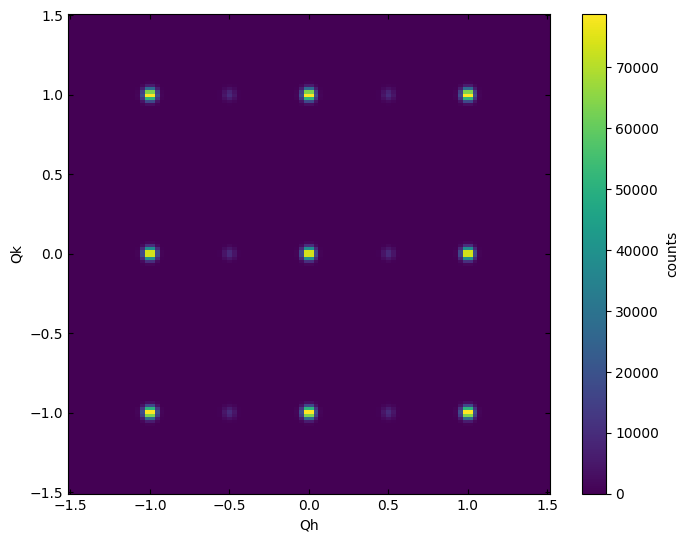

In [68]:
from nxs_analysis_tools.datareduction import plot_slice
plot_slice(xtl.datasets['15'][:,:,0.0])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Qh 0.0 0.0', ylabel='counts'>)

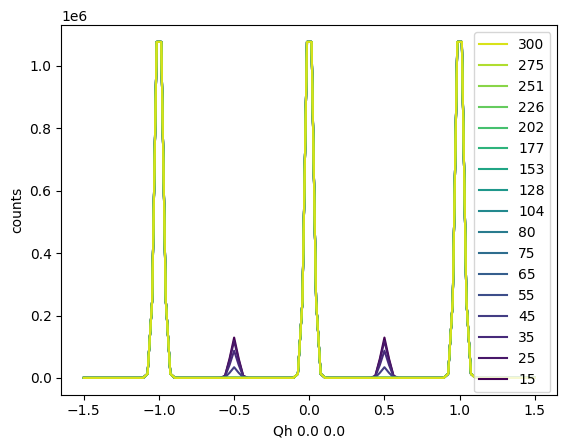

In [69]:
import matplotlib.pyplot as plt

xtl.cut_data(center=(0.0,0.0,0.0), window=(1.5,0.2,0.2))
xtl.plot_linecuts()
# plt.gca().set(ylim=(0,1000))

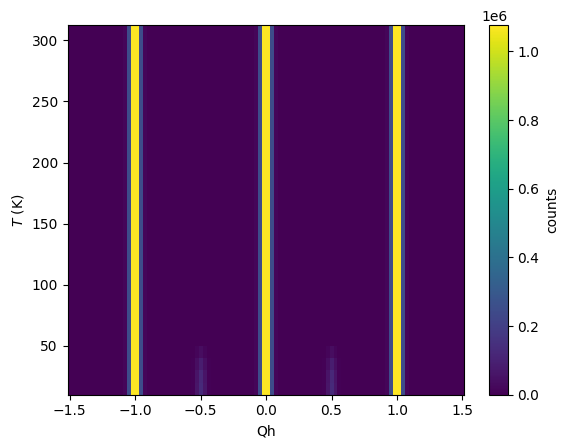

In [70]:
xtl.plot_linecuts_heatmap()